# 작물 잎 사진으로 질병 분류하기

## 데이터 분할

* 데이터 분할을 위한 디렉토리 생성

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd


def draw_img(img_np, cmap='color', size=None, ratio=None, title=None):
    # cmap에 따라 컬러 or 흑백 이미지 그림
    %matplotlib inline
    
    if type(img_np) != np.ndarray:
        img_np = read_img_to_np(img_np, cmap=cmap)
    
    print(f"shape: {img_np.shape}")
    
    if size:
        plt.figure(figsize=size)
    elif ratio:
        plt.figure(figsize=(8*ratio, 8*ratio))
    else:
        plt.figure()
    
    if title:
        plt.title(title, fontsize=15)
    
    if len(img_np.shape) == 3:
        plt.imshow(img_np)
    else:
        plt.imshow(img_np, cmap="gray")
    
    plt.show()

In [2]:
import os
import shutil
 
original_dataset_dir = './dataset/leaf_diseases/'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = './splitted' 
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train') 
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'val')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
    for cls in classes_list:     
        os.mkdir(os.path.join(train_dir, cls))
        os.mkdir(os.path.join(validation_dir, cls))
        os.mkdir(os.path.join(test_dir, cls))

* 데이터 분할과 클래스별 데이터 수 확인

In [3]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)


Train size( Potato___Early_blight ):  600
Validation size( Potato___Early_blight ):  200
Test size( Potato___Early_blight ):  200
Train size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  600
Validation size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  200
Test size( Tomato___Tomato_Yellow_Leaf_Curl_Virus ):  200
Train size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  600
Validation size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  200
Test size( Grape___Leaf_blight_(Isariopsis_Leaf_Spot) ):  200
Train size( Corn___healthy ):  600
Validation size( Corn___healthy ):  200
Test size( Corn___healthy ):  200
Train size( Pepper,_bell___healthy ):  600
Validation size( Pepper,_bell___healthy ):  200
Test size( Pepper,_bell___healthy ):  200
Train size( Strawberry___Leaf_scorch ):  600
Validation size( Strawberry___Leaf_scorch ):  200
Test size( Strawberry___Leaf_scorch ):  200
Train size( Tomato___Early_blight ):  600
Validation size( Tomato___Early_blight ):  200
Test size( Tomato___Early_

## 베이스라인 모델 학습

* 베이스라인 모델 학습을 위한 준비

In [4]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 128  # 256 
EPOCH = 100 
IMG_RESIZE = 256    # 기본은 64였음
TOTAL_CLASSES = 10

In [5]:
DEVICE

device(type='cuda')

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((IMG_RESIZE,IMG_RESIZE)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root='./splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='./splitted/val', transform=transform_base)

print(
    f"train sample cnt: {len(train_dataset)}\nval sample cnt: {len(val_dataset)}"
)

train sample cnt: 6000
val sample cnt: 2000


In [7]:
train_dataset.classes

['Corn___healthy',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Strawberry___Leaf_scorch',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

torch.Size([3, 256, 256]) 0
shape: (256, 256, 3)


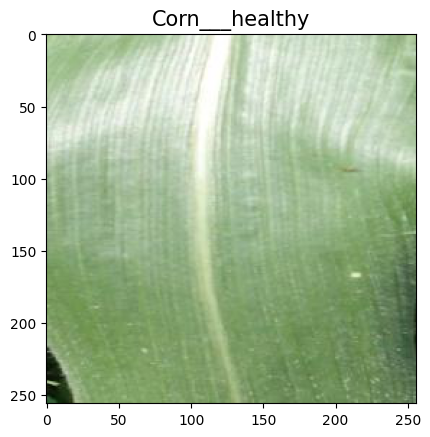

In [8]:
# img, label sample 확인
select_sample_idx = 0

img_sample, label = train_dataset[select_sample_idx][0], train_dataset[select_sample_idx][1]
print(img_sample.shape, label)
img_sample = img_sample.permute(1, 2, 0)
img_sample = np.array(img_sample)

draw_img(img_sample, cmap='color', title = train_dataset.classes[label])

In [9]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

* 베이스라인 모델 설계
  * 3 Conv layers custom model.

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, TOTAL_CLASSES) 
    
    def forward(self, x):  
#         print(x.shape, "!!")
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
#         print(x.shape)
        x = self.pool(x)
#         print(x.shape)
        x = F.dropout(x, p=0.25, training=self.training)

#         x = x.view(-1, 4096)  # img size를 미리 계산해둔거라 변형가능하도록 수정
        x = x.view(x.size(0), 4096, -1)
        x = torch.mean(x, dim=2)
        

#         print(x.shape, "x view")
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 
#         print(x.shape, "@@")

        return F.log_softmax(x, dim=1)  

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

* 모델 학습을 위한 함수

In [11]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        
        
        optimizer.zero_grad() 
        output = model(data)  
#         print(data.shape, target.shape, output.shape)
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

* 모델 평가를 위한 함수

In [12]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

## 모델 학습 (baseline)

In [ ]:

epoch_time_list = list()
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
        epoch_time_list.append(time_elapsed)
    model.load_state_dict(best_model_wts)  
    
    if epoch == 2:
        return model
    return model
 

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  	 #(16)
torch.save(base,'baseline.pt')

-------------- epoch 1 ----------------
train Loss: 1.6010, Accuracy: 48.87%
val Loss: 1.6036, Accuracy: 49.45%
Completed in 0m 40s
-------------- epoch 2 ----------------
train Loss: 1.0394, Accuracy: 66.15%
val Loss: 1.0409, Accuracy: 65.40%
Completed in 0m 34s
-------------- epoch 3 ----------------
train Loss: 0.7417, Accuracy: 77.53%
val Loss: 0.7579, Accuracy: 76.15%
Completed in 0m 33s
-------------- epoch 4 ----------------
train Loss: 0.6045, Accuracy: 80.62%
val Loss: 0.6381, Accuracy: 79.05%
Completed in 0m 33s
-------------- epoch 5 ----------------
train Loss: 0.4591, Accuracy: 84.57%
val Loss: 0.4896, Accuracy: 82.30%
Completed in 0m 33s
-------------- epoch 6 ----------------
train Loss: 0.4353, Accuracy: 85.32%
val Loss: 0.4695, Accuracy: 83.75%
Completed in 0m 33s
-------------- epoch 7 ----------------
train Loss: 0.3504, Accuracy: 88.48%
val Loss: 0.4011, Accuracy: 86.95%
Completed in 0m 34s
-------------- epoch 8 ----------------
train Loss: 0.2566, Accuracy: 92.10%

In [ ]:
total_time = np.array(epoch_time_list).sum()
print('Completed in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))

In [ ]:
# 시간 측정 테이블 저장

time_result_dir = "learning_time"
out_fname = 'time_exp1.csv'
if not os.path.exists(time_result_dir):
    os.makedirs(time_result_dir)

df = pd.DataFrame(epoch_time_list, columns=["3_conv_model"])
file_name = os.path.join(time_result_dir, out_fname)
df.to_csv(file_name, index=False)
df.head()

## Transfer Learning 모델 학습

* Transfer Learning을 위한 준비

In [ ]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize([IMG_RESIZE, IMG_RESIZE]), 
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),  
#         transforms.RandomCrop(52), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ]),
    
    'val': transforms.Compose([transforms.Resize([IMG_RESIZE, IMG_RESIZE]),  
#         transforms.RandomCrop(52), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
}

In [ ]:
data_dir = './splitted' 
image_datasets = {x: ImageFolder(root=os.path.join(data_dir, x), transform=data_transforms[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']} 
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

In [ ]:
img, label = next(iter(dataloaders['train']))
img.shape, label.shape

* Pre-Trained Model 불러오기

In [ ]:
from torchvision import models
 
resnet = models.resnet50(pretrained=True)  
num_ftrs = resnet.fc.in_features   
resnet.fc = nn.Linear(num_ftrs, TOTAL_CLASSES) 
resnet = resnet.to(DEVICE)
 
criterion = nn.CrossEntropyLoss() 
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
 
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 

* Pre-Trained Model의 일부 Layer Freeze하기

In [ ]:
ct = 0 
for child in resnet.children():  
    ct += 1  
    if ct < 6: 
        for param in child.parameters():
            param.requires_grad = False

* Transfer Learning 모델 학습과 검증을 위한 함수

In [ ]:
epoch_time_list2 = list()
def train_resnet(model, criterion, optimizer, scheduler, num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())  
    best_acc = 0.0  
    
    for epoch in range(num_epochs):
        print('-------------- epoch {} ----------------'.format(epoch+1)) 
        since = time.time()                                     
        for phase in ['train', 'val']: 
            if phase == 'train': 
                model.train() 
            else:
                model.eval()     
 
            running_loss = 0.0  
            running_corrects = 0  
 
            
            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(DEVICE)  
                labels = labels.to(DEVICE)  
                
                optimizer.zero_grad() 
                
                with torch.set_grad_enabled(phase == 'train'):  
                    outputs = model(inputs)  
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)  
    
                    if phase == 'train':   
                        loss.backward()
                        optimizer.step()
 
                running_loss += loss.item() * inputs.size(0)  
                running_corrects += torch.sum(preds == labels.data)  
            if phase == 'train':  
                scheduler.step()
 
            epoch_loss = running_loss/dataset_sizes[phase]  
            epoch_acc = running_corrects.double()/dataset_sizes[phase]  
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) 
 
          
            if phase == 'val' and epoch_acc > best_acc: 
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        time_elapsed = time.time() - since  
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        epoch_time_list2.append(time_elapsed)
    print('Best val Acc: {:4f}'.format(best_acc))
 
    model.load_state_dict(best_model_wts) 

    return model

* 모델 학습을 실행하기

In [ ]:
model_resnet50 = train_resnet(resnet, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=EPOCH) 

torch.save(model_resnet50, 'resnet50.pt')

In [ ]:
total_time = np.array(epoch_time_list2).sum()
print('Completed in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))

In [ ]:
# 시간 측정 테이블 저장

time_result_dir = "learning_time"
out_fname = 'time_exp2.csv'
if not os.path.exists(time_result_dir):
    os.makedirs(time_result_dir)

df = pd.DataFrame(epoch_time_list2, columns=["resnet50_conv_model"])
file_name = os.path.join(time_result_dir, out_fname)
df.to_csv(file_name, index=False)
df.head()

## 모델 평가

* 베이스라인 모델 평가를 위한 전처리하기

In [ ]:
transform_base = transforms.Compose([transforms.Resize([IMG_RESIZE,IMG_RESIZE]),transforms.ToTensor()])
test_base = ImageFolder(root='./splitted/test',transform=transform_base)  
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

* Transfer Learning모델 평가를 위한 전처리하기

In [ ]:
transform_resNet = transforms.Compose([
        transforms.Resize([IMG_RESIZE,IMG_RESIZE]),  
#         transforms.RandomCrop(52),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ])
    
test_resNet = ImageFolder(root='./splitted/test', transform=transform_resNet) 
test_loader_resNet = torch.utils.data.DataLoader(test_resNet, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

* 베이스라인 모델 성능 평가하기

In [ ]:
baseline=torch.load('baseline.pt') 
baseline.eval()  
test_loss, test_accuracy = evaluate(baseline, test_loader_base)

print('baseline test acc:  ', test_accuracy)

* Transfer Learning 모델 성능 평가하기

In [ ]:
resnet50=torch.load('resnet50.pt') 
resnet50.eval()  
test_loss, test_accuracy = evaluate(resnet50, test_loader_resNet)

print('ResNet test acc:  ', test_accuracy)